# Titanic dataset: implementation and comparison of 3 classifiers
The purpose of this exercise is to predict survival of Titanic passengers by applying classification algorithms in a structured and consistent way.  
I selected 3 different algorithms:
* Logistic Regression, for its simplicity
* Random Forest, to have a non-linear classifier
* Support Vector Machine, to study the impact of kernels

Each algorithm was tuned by selecting the best set of hyperparameters with a grid search. The performance for each set of parameters was evaluated with k-fold cross validation (10 folds for logistic regression, and 3 folds for random forest trees and SVM).  
The performance of each algorithm is estimated by its mean accuracy with its standard error obtained with the cross vaidation.     
The results are displayed as graphs and discussed to analyze the bias-variance tradeoff.  

As a final result, the Support Vector Classifer was applied to the test set, and gave a 78.49% accuracy score.

In [1]:
import numpy as np
import pandas as pd

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

from sklearn.model_selection import GridSearchCV

from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = 10, 5
import seaborn as sns
sns.set_style("darkgrid")

## Exploring the data
The target is a binary variable (Survived) with value 0 (died) or 1 (survived).    
There are 10 explanatory variables:
* 5 numerical variables: passenger class, age, number of siblings/spouse, number of children/parents, fare
* 4 categorical variables: sex, ticket, cabin, port of embarkation, plus the name

In [2]:
# Load training set
train_raw = pd.read_csv('./input/train.csv', index_col = 'PassengerId')
target = 'Survived'
features = [c for c in list(train_raw.columns.values) if c != target]

# list of features
train_raw.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


### Distribution of the target 
The distribution of the target on the training set shows that 61.62% of the passengers died.  
This is the naive baseline to assess the gain obtained from the classification algorithms. 

In [3]:
# =============================================================================
# # DATA EXPLORATION & VISUALIZATION
# =============================================================================

#target values with their frequency
pd.value_counts(train_raw[target].values)/train_raw.shape[0]

0    0.616162
1    0.383838
dtype: float64

### Influence of sex and passenger class on the survival rate
Plotting the survival rate as a function of sex and passenger class shows:
* a high influence of sex, with female having a higher survival rate
* an effect of passenger class, showing non-linearity and dependance with sex 

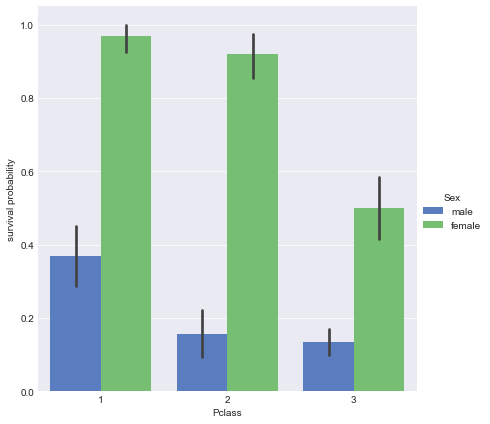

In [4]:
# visualization of interactions btw survival and sex/class 
g = sns.factorplot(x='Pclass', y=target, hue='Sex', data=train_raw,
                   size=6, kind='bar', palette='muted')
g.despine(left=True)
g.set_ylabels("survival probability")

### Impact of age
There is a slight tendency of higher rate of survival for male children, and no visible impact for female passengers

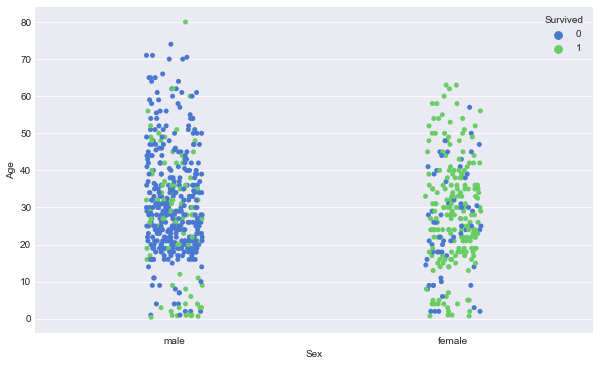

In [5]:
# visualization of interactions btw survival and sex/age 
plt.rcParams['figure.figsize'] = 10, 6
sns.stripplot(x='Sex', y='Age', hue=target,
                       data=train_raw, jitter=True, palette='muted')

## Preprocessing data
The data is processed as below before applying the classification algorithms:
* missing values in Age variable are filled with the median  
* title is extracted from Name, as a proxy for male adult (Mr), and priority passengers (Master, Mrs, Miss)  
* binary variable (Sex) is converted to numeric values  
* categorical variables (PClass, Title) are transformed by creating dummy variables (dropping one of each feature) 

In [6]:
# =============================================================================
# # DATA PREPROCESSING
# =============================================================================
   
def data_preprocessing(data):
    # we do not touch the original dataframe
    df = data.copy()  

    # default age as median of training set
    default_age = train_raw['Age'].median()
    df['Age'].fillna(value=default_age, inplace=True)
      
    # extract title from Name
    df['Title'] = df['Name'].apply(lambda x: 
        x[x.find(',')+2:x.find('.')])
    # and regroup values to get a proxy for male/female + child/adult
    df['Title'].replace(['Mr','Don','Rev','Dr','Major','Sir','Col',
      'Capt','Jonkheer'], 'Mr', inplace=True) 
    df['Title'].replace(['Mrs','Mme','Lady','the Countess','Dona'], 
      'Mrs', inplace=True)     
    df['Title'].replace(['Miss','Ms','Mlle'], 'Miss', inplace=True) 
        
    # convert binary variables to 0/1 int values
    mapping = {'Sex': {'female': 0, 'male': 1}}
    df.replace(mapping, inplace=True)
    
    # encode categorical variables: Pclass, Embarked, Title
    return pd.get_dummies(df, columns=['Pclass', 'Title'], 
                          drop_first=True)

train_pp = data_preprocessing(train_raw)      

Features not used in the analysis are dropped.    
The features are scaled to 0 mean and unit variance, using StandardScaler (required to use SVM algorithm).

In [7]:
#%% PREPARE DATA FOR MACHINE LEARNING

train_set = train_pp.copy()
# drop features not used for the analysis
train_set.drop(columns=['Name','Ticket','Embarked','Cabin'], inplace=True)
X = train_set[[c for c in list(train_set.columns.values) if c != target]]
y = train_set[target]

# scale data
scaler = StandardScaler()
scaler.fit(X)
X = scaler.transform(X)

## Logistic regression
A logistic regression is implemented and fit using a 10-fold cross validation.    
The hyper parameters are tuned using a grid search:
* penalty: l1 or l2
* C (inverse of regularization strength): from 10-2 to 10+2 with 0.1 increase of the exponent 

In [8]:
# =============================================================================
# # LOGISTIC REGRESSION
# =============================================================================
clf1 = LogisticRegression()

# tune hyper-parameter using grid search
C = np.power(10, np.linspace(-2,2,41))
param_grid = {'penalty': ['l1','l2'],
              'C': C}
grid_search = GridSearchCV(clf1, param_grid=param_grid,
                           return_train_score=True,
                           cv=10) #10-fold validation 
grid_search.fit(X, y)

m = grid_search.best_score_
s = grid_search.cv_results_['std_test_score'][grid_search.best_index_]
print('Best score = {:.4f}+/-{:.4f} (parameters: {})'.format(
        m, s, grid_search.best_params_))

Best score = 0.8272+/-0.0334 (parameters: {'C': 0.1, 'penalty': 'l1'})


The mean accuracy of the train and test sets is plotted against the regularization strength.  
The plot shows a drop of the accuracy for high regularization, indicating high bias.   
But there is no sign of high variance as the train and test scores are close to each other.   

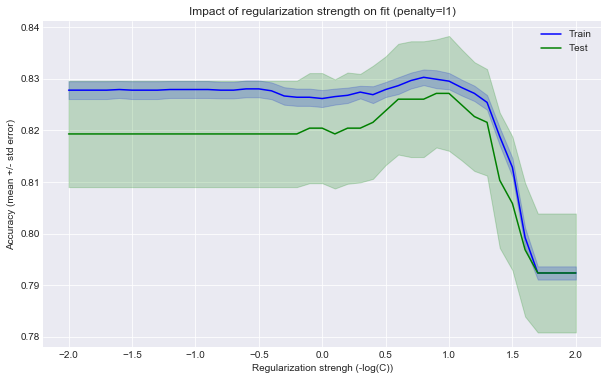

In [9]:
#%% plot results of the grid search for hyper-parameters tuning

# load GridSearch results in a dataframe
df = pd.DataFrame.from_dict(grid_search.cv_results_)
# keep only rows for best penalty 
penalty = grid_search.best_params_['penalty']
df = df[df.param_penalty==penalty]

x_plot = -np.log10(df['param_C'].astype(np.float64))   # to be able to apply log10 function
# plot mean train value for best penalty
y_plot = df['mean_train_score']
y_dev = df['std_train_score']/3
plt.plot(x_plot, y_plot, label='Train',color='blue')
plt.fill_between(x_plot, y_plot-y_dev, y_plot+y_dev, color='blue', 
                 alpha=0.2)
# plot mean test value for best penalty
y_plot = df['mean_test_score']
y_dev = df['std_test_score']/3
plt.plot(x_plot, y_plot, label='Test', color='green')
plt.fill_between(x_plot, y_plot-y_dev, y_plot+y_dev, color='green', 
                 alpha=0.2)

# title, axis labels and legend
plt.title('Impact of regularization strength on fit (penalty=' 
                                                     + penalty + ')')
plt.xlabel('Regularization strengh (-log(C))')
plt.ylabel('Accuracy (mean +/- std error)')
plt.legend()
plt.show()

## Random Forest
A random forest algorithm is implemented and fit in the same way, with the following hyper parameters:
* n_estimators (number of trees): from 10 to 30 by increment 5
* max_features: 2 to 10
* min_samples_leaf: 1 to 10 

In [10]:
# =============================================================================
# # RANDOM FOREST
# =============================================================================

clf2 = RandomForestClassifier()

# tune hyper-parameter using grid search
param_grid = {'n_estimators': [i for i in range(10,31,5)],
              'max_features': [i for i in range(2,10)],
              'min_samples_leaf': [i for i in range(1,20)]}
grid_search = GridSearchCV(clf2, param_grid=param_grid,
                           return_train_score=True, refit=True,
                           cv=3) #3-fold validation
grid_search.fit(X, y)

m = grid_search.best_score_
s = grid_search.cv_results_['std_test_score'][grid_search.best_index_]
print('Best score = {:.4f}+/-{:.4f} (parameters: {})'.format(
        m, s, grid_search.best_params_))

Best score = 0.8485+/-0.0225 (parameters: {'max_features': 8, 'min_samples_leaf': 4, 'n_estimators': 10})


The mean accuracy of the train and test sets is plotted against the minimum size of a leaf.    
There is a clear overfit of the model for smaller leaf size. 
We note also that the difference between the training and test accuracy is large.

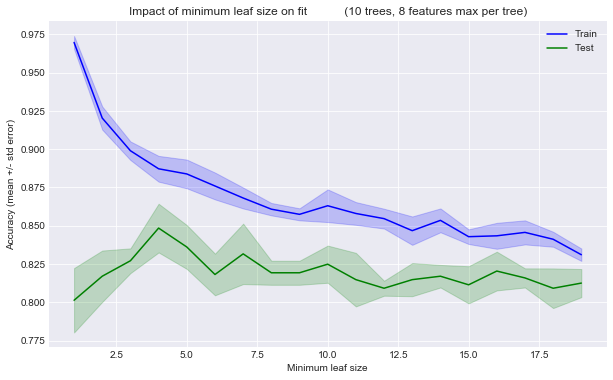

In [11]:
#%% plot results of the grid search for hyper-parameters tuning

# load GridSearch results in a dataframe
df = pd.DataFrame.from_dict(grid_search.cv_results_)
# keep only rows for best n_estimator et max_features parameters 
n_trees = grid_search.best_params_['n_estimators']
n_feat = grid_search.best_params_['max_features']
df = df[(df.param_n_estimators==n_trees) & 
        (df.param_max_features==n_feat)]

#need to specify type for fill_between
x_plot = df['param_min_samples_leaf'].astype(np.int64) 
# plot mean train value for best number of estimators
y_plot = df['mean_train_score'].values
y_dev = df['std_train_score'].values/(2**0.5)
plt.plot(x_plot, y_plot, label='Train',color='blue')
plt.fill_between(x_plot, y_plot-y_dev, y_plot+y_dev, color='blue', 
               alpha=0.2)
# plot mean test value for best penalty
y_plot = df['mean_test_score']
y_dev = df['std_test_score']/(2**0.5)
plt.plot(x_plot, y_plot, label='Test', color='green')
plt.fill_between(x_plot, y_plot-y_dev, y_plot+y_dev, color='green', 
                 alpha=0.2)

# title, axis labels and legend
plt.title('Impact of minimum leaf size on fit \
          ({} trees, {} features max per tree)'.format(n_trees, n_feat))
plt.xlabel('Minimum leaf size')
plt.ylabel('Accuracy (mean +/- std error)')
plt.legend()
plt.show()



## Support Vector Machine
Finnaly, a SVM classifier is implemented with a search over the following hyperparameter grid:
* type of kernel: polynomial, gaussian, sigmoid
* C (penalty coefficient of the error term, default=1.0): from 0.2 to 2 by increment of 0.2
* gamma: 0.01 t0 0.1 by step of 0.01
* degree for the polynomial kernel: 2 or 3 

In [12]:
# =============================================================================
# # SVM
# =============================================================================

clf3 = SVC()

# tune hyper-parameter using grid search
C = np.power(10, np.linspace(-1,1,9))
gamma = np.power(10, np.linspace(-2,0,11))
param_grid = [{'kernel': ['poly'],
               'degree': [2,3],
              'C': C,
              'gamma': gamma},
              {'kernel': ['rbf','sigmoid'],
              'C': C,
              'gamma': gamma}] 

grid_search = GridSearchCV(clf3, param_grid=param_grid,
                           return_train_score=True, refit=True,
                           cv=3) #3-fold validation 
grid_search.fit(X, y)

m = grid_search.best_score_
s = grid_search.cv_results_['std_test_score'][grid_search.best_index_]
print('Best score = {:.4f}+/-{:.4f} (parameters: {})'.format(
        m, s, grid_search.best_params_))

Best score = 0.8350+/-0.0099 (parameters: {'C': 1.0, 'gamma': 0.06309573444801933, 'kernel': 'rbf'})


Accuracy for low C values (smoother decision surface) is affected by bias. High values of C gives the model freedom to select more samples as support vectors, but start to exhibit overfitting from loc(C) = 0.25.

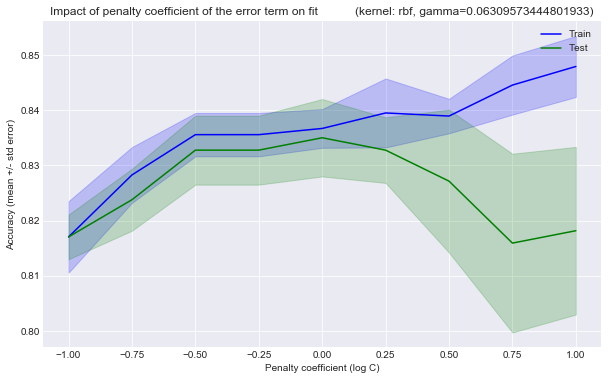

In [15]:
# load GridSearch results in a dataframe
df = pd.DataFrame.from_dict(grid_search.cv_results_)
# keep only rows for best n_estimator et max_features parameters 
k = grid_search.best_params_['kernel']
g = grid_search.best_params_['gamma']
df = df[(df.param_kernel==k) & 
        (df.param_gamma==g)]

#need to specify type for fill_between
x_plot = np.log10(C) 
# plot mean train value for best number of estimators
y_plot = df['mean_train_score'].values
y_dev = df['std_train_score'].values/(2**0.5)
plt.plot(x_plot, y_plot, label='Train',color='blue')
plt.fill_between(x_plot, y_plot-y_dev, y_plot+y_dev, color='blue', 
               alpha=0.2)
# plot mean test value for best penalty
y_plot = df['mean_test_score']
y_dev = df['std_test_score']/(2**0.5)
plt.plot(x_plot, y_plot, label='Test', color='green')
plt.fill_between(x_plot, y_plot-y_dev, y_plot+y_dev, color='green', 
                 alpha=0.2)

# title, axis labels and legend
plt.title('Impact of penalty coefficient of the error term on fit \
          (kernel: {}, gamma={})'.format(k, g))
plt.xlabel('Penalty coefficient (log C)')
plt.ylabel('Accuracy (mean +/- std error)')
plt.legend()
plt.show()

## Using SVC classifier for prediction on the test set
Select the SVC classifier with the optimal hyper parameters and retrain it on the full training set.  
Read the test set, preprocess it and make predictions.

The accuracy of the predictions was 78.749% (top 25%). 

In [14]:
# =============================================================================
# # Make prediction on the test set and submit results
# =============================================================================

# using best SVC and refit on the total training set
clf = grid_search.best_estimator_
clf.fit(X,y)

# read and preprocess test data
test_raw = pd.read_csv('./input/test.csv', index_col = 'PassengerId')
test_raw['Fare'].fillna(value=test_raw['Fare'].mean(), inplace=True) 

test_pp = data_preprocessing(test_raw)    
test_pp.drop(columns=['Name','Ticket','Embarked','Cabin'], inplace=True)
X_test = scaler.transform(test_pp)

# make prediction and save the result
y_pred = clf.predict(X_test)
test_raw['Survived'] = y_pred

test_raw.to_csv('./output/result.csv', 
                columns=['Survived'],
                header=True,
                index=True)
